In [12]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [13]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
                            img_dir='archive/RAF-DB/train/',
                            transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
#                             img_dir='data/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
                            img_dir='archive/RAF-DB/test/',
                            transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
#                             img_dir='data/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.2)
        
        self.classifier = nn.Sequential(
            nn.Linear(16384, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 6)  
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv6(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG16().to(device)

In [16]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 72460742


In [18]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 610/610 [01:04<00:00,  9.53it/s]


Epoch 1, Train Loss: 1.2828373197160783, Train Accuracy: 0.5330391955674123, Test Loss: 1.4238814489046732, Test Accuracy: 0.5333054042731462, Validation Loss: 1.663772896716469, Validation Accuracy: 0.2904841402337229


Epoch 2/80: 100%|██████████| 610/610 [01:03<00:00,  9.68it/s]


Epoch 2, Train Loss: 0.9769112457505992, Train Accuracy: 0.6469320746973117, Test Loss: 1.4485028878847759, Test Accuracy: 0.5203183912861332, Validation Loss: 1.4865855700091313, Validation Accuracy: 0.4373956594323873


Epoch 3/80: 100%|██████████| 610/610 [01:02<00:00,  9.81it/s]


Epoch 3, Train Loss: 0.8364840588120164, Train Accuracy: 0.7022368151036322, Test Loss: 1.304572106997172, Test Accuracy: 0.48470883954754923, Validation Loss: 1.4204194796712775, Validation Accuracy: 0.4040066777963272
No improvement in validation accuracy for 1 epochs.


Epoch 4/80: 100%|██████████| 610/610 [01:02<00:00,  9.73it/s]


Epoch 4, Train Loss: 0.7472495125209699, Train Accuracy: 0.7328134619331007, Test Loss: 0.9748357458909352, Test Accuracy: 0.673229995810641, Validation Loss: 1.2884161535062288, Validation Accuracy: 0.4974958263772955


Epoch 5/80: 100%|██████████| 610/610 [01:02<00:00,  9.77it/s]


Epoch 5, Train Loss: 0.6916967585789742, Train Accuracy: 0.7566180997332239, Test Loss: 1.0916911137104035, Test Accuracy: 0.6644323418516966, Validation Loss: 1.2933457054589923, Validation Accuracy: 0.5141903171953256


Epoch 6/80: 100%|██████████| 610/610 [01:02<00:00,  9.73it/s]


Epoch 6, Train Loss: 0.6399579325293908, Train Accuracy: 0.7770367330186744, Test Loss: 0.9001533305644989, Test Accuracy: 0.711772098868873, Validation Loss: 1.1802823669032048, Validation Accuracy: 0.5709515859766278


Epoch 7/80: 100%|██████████| 610/610 [01:03<00:00,  9.66it/s]


Epoch 7, Train Loss: 0.6033422695930863, Train Accuracy: 0.7890416581161502, Test Loss: 0.829041232864062, Test Accuracy: 0.7452869710934227, Validation Loss: 1.0972711679182554, Validation Accuracy: 0.5943238731218697


Epoch 8/80: 100%|██████████| 610/610 [01:02<00:00,  9.72it/s]


Epoch 8, Train Loss: 0.562863233264299, Train Accuracy: 0.8037143443463985, Test Loss: 0.7838886451721191, Test Accuracy: 0.7653958944281525, Validation Loss: 1.1324620937046253, Validation Accuracy: 0.5709515859766278
No improvement in validation accuracy for 1 epochs.


Epoch 9/80: 100%|██████████| 610/610 [01:02<00:00,  9.73it/s]


Epoch 9, Train Loss: 0.5361132087033303, Train Accuracy: 0.8138723578904166, Test Loss: 0.8611283059914907, Test Accuracy: 0.7616254713028907, Validation Loss: 1.0788404549423016, Validation Accuracy: 0.6243739565943238


Epoch 10/80: 100%|██████████| 610/610 [01:03<00:00,  9.63it/s]


Epoch 10, Train Loss: 0.507816162986345, Train Accuracy: 0.820644366919762, Test Loss: 0.9251790161927541, Test Accuracy: 0.6954335986594051, Validation Loss: 1.0740296683813397, Validation Accuracy: 0.6126878130217028
No improvement in validation accuracy for 1 epochs.


Epoch 11/80: 100%|██████████| 610/610 [01:02<00:00,  9.76it/s]


Epoch 11, Train Loss: 0.4808395690544218, Train Accuracy: 0.8335727477939667, Test Loss: 0.8708941058317821, Test Accuracy: 0.7239212400502724, Validation Loss: 1.0202742391511013, Validation Accuracy: 0.6143572621035058
No improvement in validation accuracy for 2 epochs.


Epoch 12/80: 100%|██████████| 610/610 [01:02<00:00,  9.70it/s]


Epoch 12, Train Loss: 0.4615080732058306, Train Accuracy: 0.8322388672275806, Test Loss: 0.7049832590421041, Test Accuracy: 0.7666527021365731, Validation Loss: 1.0154985361977626, Validation Accuracy: 0.6277128547579299


Epoch 13/80: 100%|██████████| 610/610 [01:02<00:00,  9.72it/s]


Epoch 13, Train Loss: 0.4390006747860156, Train Accuracy: 0.8458854914836856, Test Loss: 0.8375834516684214, Test Accuracy: 0.718475073313783, Validation Loss: 0.9887505440335524, Validation Accuracy: 0.6210350584307178
No improvement in validation accuracy for 1 epochs.


Epoch 14/80: 100%|██████████| 610/610 [01:02<00:00,  9.74it/s]


Epoch 14, Train Loss: 0.4158345831741319, Train Accuracy: 0.8587112661604761, Test Loss: 0.709744483033816, Test Accuracy: 0.7494763301214914, Validation Loss: 1.0862404704093933, Validation Accuracy: 0.5843071786310517
No improvement in validation accuracy for 2 epochs.


Epoch 15/80: 100%|██████████| 610/610 [01:02<00:00,  9.73it/s]


Epoch 15, Train Loss: 0.3999359382148527, Train Accuracy: 0.8542991996716601, Test Loss: 0.6693577942252159, Test Accuracy: 0.7997486384583159, Validation Loss: 0.9208073914051056, Validation Accuracy: 0.6828046744574291


Epoch 16/80: 100%|██████████| 610/610 [01:02<00:00,  9.71it/s]


Epoch 16, Train Loss: 0.3743938814909732, Train Accuracy: 0.8690744920993227, Test Loss: 0.7339180888732274, Test Accuracy: 0.7545035609551739, Validation Loss: 1.0028949019156004, Validation Accuracy: 0.6277128547579299
No improvement in validation accuracy for 1 epochs.


Epoch 17/80: 100%|██████████| 610/610 [01:02<00:00,  9.73it/s]


Epoch 17, Train Loss: 0.35155925000788735, Train Accuracy: 0.8764621383131541, Test Loss: 0.6684368975957234, Test Accuracy: 0.7909509844993716, Validation Loss: 0.9461198386393095, Validation Accuracy: 0.671118530884808
No improvement in validation accuracy for 2 epochs.


Epoch 18/80: 100%|██████████| 610/610 [01:02<00:00,  9.78it/s]


Epoch 18, Train Loss: 0.3526337850775921, Train Accuracy: 0.8729735276010671, Test Loss: 0.6184845865766208, Test Accuracy: 0.8093841642228738, Validation Loss: 0.9984783028301439, Validation Accuracy: 0.6060100166944908
No improvement in validation accuracy for 3 epochs.


Epoch 19/80: 100%|██████████| 610/610 [01:04<00:00,  9.49it/s]


Epoch 19, Train Loss: 0.32717147228598104, Train Accuracy: 0.884978452698543, Test Loss: 0.6317673014601072, Test Accuracy: 0.8031001256807708, Validation Loss: 0.901032818775428, Validation Accuracy: 0.6861435726210351


Epoch 20/80: 100%|██████████| 610/610 [01:03<00:00,  9.64it/s]


Epoch 20, Train Loss: 0.31234775068329984, Train Accuracy: 0.8893905191873589, Test Loss: 0.6366888578732809, Test Accuracy: 0.7951403435274403, Validation Loss: 0.9304585519589876, Validation Accuracy: 0.659432387312187
No improvement in validation accuracy for 1 epochs.


Epoch 21/80: 100%|██████████| 610/610 [01:02<00:00,  9.75it/s]


Epoch 21, Train Loss: 0.30534055459572645, Train Accuracy: 0.8945208290580751, Test Loss: 0.5848815309504668, Test Accuracy: 0.8236279849183075, Validation Loss: 0.9156477168986672, Validation Accuracy: 0.6878130217028381


Epoch 22/80: 100%|██████████| 610/610 [01:02<00:00,  9.83it/s]


Epoch 22, Train Loss: 0.2813247436669714, Train Accuracy: 0.8974964087830904, Test Loss: 0.6182804243763288, Test Accuracy: 0.795978215333054, Validation Loss: 0.9212922030373624, Validation Accuracy: 0.662771285475793
No improvement in validation accuracy for 1 epochs.


Epoch 23/80: 100%|██████████| 610/610 [01:03<00:00,  9.65it/s]


Epoch 23, Train Loss: 0.26685636414703534, Train Accuracy: 0.9096039400779807, Test Loss: 0.5827753818531831, Test Accuracy: 0.8035190615835777, Validation Loss: 0.9538038396521619, Validation Accuracy: 0.6510851419031719
No improvement in validation accuracy for 2 epochs.


Epoch 24/80: 100%|██████████| 610/610 [01:03<00:00,  9.60it/s]


Epoch 24, Train Loss: 0.2751875924152612, Train Accuracy: 0.9026267186538067, Test Loss: 0.5817359533905982, Test Accuracy: 0.8031001256807708, Validation Loss: 0.8818896459905725, Validation Accuracy: 0.656093489148581
No improvement in validation accuracy for 3 epochs.


Epoch 25/80: 100%|██████████| 610/610 [01:04<00:00,  9.43it/s]


Epoch 25, Train Loss: 0.25050671926096507, Train Accuracy: 0.9142212189616253, Test Loss: 0.6017020046710968, Test Accuracy: 0.8098031001256808, Validation Loss: 0.8701494947860116, Validation Accuracy: 0.6861435726210351
No improvement in validation accuracy for 4 epochs.


Epoch 26/80: 100%|██████████| 610/610 [01:04<00:00,  9.49it/s]


Epoch 26, Train Loss: 0.2331369742842727, Train Accuracy: 0.913502975579725, Test Loss: 0.5191737445443869, Test Accuracy: 0.8332635106828655, Validation Loss: 0.9507179801401339, Validation Accuracy: 0.66110183639399
No improvement in validation accuracy for 5 epochs.


Epoch 27/80: 100%|██████████| 610/610 [01:02<00:00,  9.68it/s]


Epoch 27, Train Loss: 0.22858963891421064, Train Accuracy: 0.9153498871331829, Test Loss: 0.6082618594169616, Test Accuracy: 0.7913699204021785, Validation Loss: 0.8804705080233122, Validation Accuracy: 0.67779632721202
No improvement in validation accuracy for 6 epochs.


Epoch 28/80: 100%|██████████| 610/610 [01:04<00:00,  9.43it/s]


Epoch 28, Train Loss: 0.22151973854261833, Train Accuracy: 0.9200697722142417, Test Loss: 0.5562682830790678, Test Accuracy: 0.8060326770004189, Validation Loss: 0.9158126868699726, Validation Accuracy: 0.66110183639399
No improvement in validation accuracy for 7 epochs.


Epoch 29/80: 100%|██████████| 610/610 [01:04<00:00,  9.47it/s]


Epoch 29, Train Loss: 0.2004557840606259, Train Accuracy: 0.9271495998358301, Test Loss: 0.6140999068816503, Test Accuracy: 0.783410138248848, Validation Loss: 0.9192788067616915, Validation Accuracy: 0.6477462437395659
No improvement in validation accuracy for 8 epochs.


Epoch 30/80: 100%|██████████| 610/610 [01:02<00:00,  9.83it/s]


Epoch 30, Train Loss: 0.19022587768153335, Train Accuracy: 0.9320746973117177, Test Loss: 0.5777172661821047, Test Accuracy: 0.8072894847088395, Validation Loss: 0.8910599319558394, Validation Accuracy: 0.6828046744574291
No improvement in validation accuracy for 9 epochs.


Epoch 31/80: 100%|██████████| 610/610 [01:02<00:00,  9.72it/s]


Epoch 31, Train Loss: 0.18429720997896243, Train Accuracy: 0.9348450646419044, Test Loss: 0.6234465619921684, Test Accuracy: 0.7779639715123586, Validation Loss: 1.072875457374673, Validation Accuracy: 0.6227045075125208
No improvement in validation accuracy for 10 epochs.


Epoch 32/80: 100%|██████████| 610/610 [01:03<00:00,  9.62it/s]


Epoch 32, Train Loss: 0.17516190626449285, Train Accuracy: 0.9380258567617484, Test Loss: 0.5374131648242474, Test Accuracy: 0.8253037285295349, Validation Loss: 0.9776097896851992, Validation Accuracy: 0.659432387312187
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


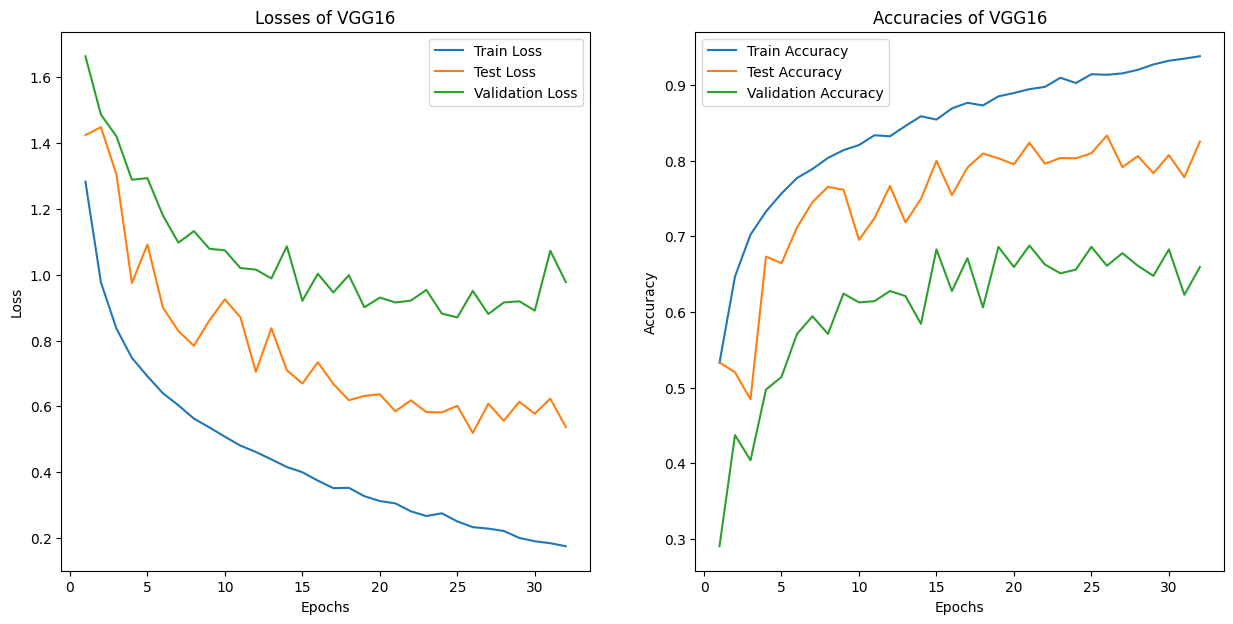

In [21]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 33), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 33), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 33), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses of VGG16') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 33), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 33), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 33), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies of VGG16') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 33), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_vgg_rafdb.csv', index=False) # change this CSV